# Imports

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
plt.rcParams.update({'font.size': 20})

__________________________________________________________________
# Introducion:

## Data cleaning process

There will be two sections in this notebook. The first portion Iteration 1, The first dataset collected in [01_sub_reddit_data](../Data/01_sub_reddits_data.csv) contained an initial 3992 records; however upon our first analysis, we found that nearly 70% of our titles were removed by a moderator. We assume that removed post violate the subreddit guidelines and wont be representative of the subreddits characteristics. Although we notice this discrepancy we continued exploring the data, so we can reference it after we gather more data. Iteration 2 will use all data from Iteration 1 because those removed post may be used as a feature.

We then went back to the data collection notebook [01_data_collecting](../Code/01_data_collecting.ipynb) and added parameters to pull post that had a minimum of 4 post and was not removed by a moderator; however, the removed by moderator parameter was deprecated. Then we proceeded to clean the data of the new column in Iteration 2. We combined Iteration 1 and Iteration 2 because we also wanted to keep the removed comments. There is a portability one subreddit has more post removed than the other, so that may be a good feature to have. 
_________________________________________________________________

# Iteration 1
____________________________________________________________________________________________
Summary:

In this iteration we will be using our initial Dateset of 3992 records to perform some preliminary exploratory data analysis. During this process we experimented with feature engineering to see the word count of the titles and what days had the most post activity. In those findings we found that the distribution of those questions were pretty even in regards to be similar across the subreddits. The only difference was that the "activity" was more popular in the Askmen subreddit.
Upon further inspection we realized that there was a significant amount of removed post in both subreddits. In our analysis the Askwomen subreddit appeared to have a higher number of removed post compared to ask men. We then moved back to the [Data collection subreddit](../Code/01_data_collecting.ipynb) and gathered an additional 2001 records implementing parameters to remove the number of removed post.
_______________________________________________________________________

# Iteration 2

For the second iteration we will repeat the process for iteration 1, but we used a few features to try to filter removed post. Originally we attempted to use a parameter to filter post tagged with removed by moderator, but found that feature to be deprecated. We noticed most removed post had less than 3 comments, so we attempted to gather data with comments greater than 5. Additionally, in this iteration we implemented a method to only get titles that use English alphabet characters.

## Load data

For the purposes of our analysis we will load in the data from our first iteration to compare some values.

In [107]:
df = pd.read_csv('../Data/01_sub_reddits_data.csv')
df2 = pd.read_csv('../Data/02_sub_reddits_data.csv')
df2.head(1)

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,updated_utc,edited_on,utc_datetime_str,author_created_utc,retrieved_on,link_flair_template_id,author_cakeday,call_to_action,post_hint,preview
0,AskMen,"I want to give my man a good gift, I don’t thi...",t2_dusj7gug,0,"What’s better: Xbox, or Play station ?",[],r/AskMen,False,6,NaN,...,1669991145,1.669862e+09,2022-12-01 01:11:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
len(df2), len(df)

(7990, 3992)

## Clean and select features

In [109]:
clean_df=df[['id', 'subreddit','title', 'utc_datetime_str','num_comments']]
clean_df_2=df2[['id', 'subreddit','title', 'utc_datetime_str','num_comments']]

In [110]:
clean_df_2=df2[['id', 'subreddit','title', 'utc_datetime_str','num_comments']]
clean_df_2.set_index('id', inplace=True)

In [ ]:
#remove any duplicates
clean_df_2.drop_duplicates(inplace= True)

In [112]:
len(clean_df_2)

7990

In [113]:
'''
Used this method from stackoverflow: https://stackoverflow.com/questions/65012603/removing-rows-contains-non-english-words-in-pandas-dataframe
Originally used a package to spell check each word for english, but the package didnt account for slang and puncuation
Regular expression required multiple nested loops which would not be scaleable
'''
clean_df_2= clean_df_2[clean_df_2['title'].map(lambda title: title.isascii())]

In [114]:
clean_df_2.head(2)

,subreddit,title,utc_datetime_str,num_comments
id,,,,
z99f3w,AskMen,what do athlete think about having some things...,2022-12-01 01:03:02,21
z991l7,AskMen,Why is the idea of permanent sleep so appealing?,2022-12-01 00:47:36,38


## Feature engineering

### Convert timestamp string to a datetime datatyp

In [115]:
clean_df_2.loc[:, 'utc_datetime_str']= pd.to_datetime(clean_df_2.loc[:, 'utc_datetime_str'])

In [116]:
clean_df_2.dtypes

subreddit                   object
title                       object
utc_datetime_str    datetime64[ns]
num_comments                 int64
dtype: object

In [117]:
clean_df_2.head(1)

,subreddit,title,utc_datetime_str,num_comments
id,,,,
z99f3w,AskMen,what do athlete think about having some things...,2022-12-01 01:03:02,21


### Get the day from the datetime stamp

In [118]:
clean_df_2['day_name'] = clean_df_2['utc_datetime_str'].apply(lambda x: x.day_name())

In [119]:
clean_df_2.head(3)

,subreddit,title,utc_datetime_str,num_comments,day_name
id,,,,,
z99f3w,AskMen,what do athlete think about having some things...,2022-12-01 01:03:02,21,Thursday
z991l7,AskMen,Why is the idea of permanent sleep so appealing?,2022-12-01 00:47:36,38,Thursday
z98yxa,AskMen,Why do my eyebrows start itching and get red a...,2022-12-01 00:44:41,7,Thursday


### Creating a title word count column

In [120]:
clean_df_2['title_word_count'] = clean_df_2['title'].apply(lambda text: len(text.split()))

In [121]:
clean_df_2['title_word_count'].value_counts(sort=True).head(10)

8     588
9     579
12    546
10    542
11    535
7     472
13    421
14    395
6     348
15    337
Name: title_word_count, dtype: int64

Text(0.5, 0, 'Word count')

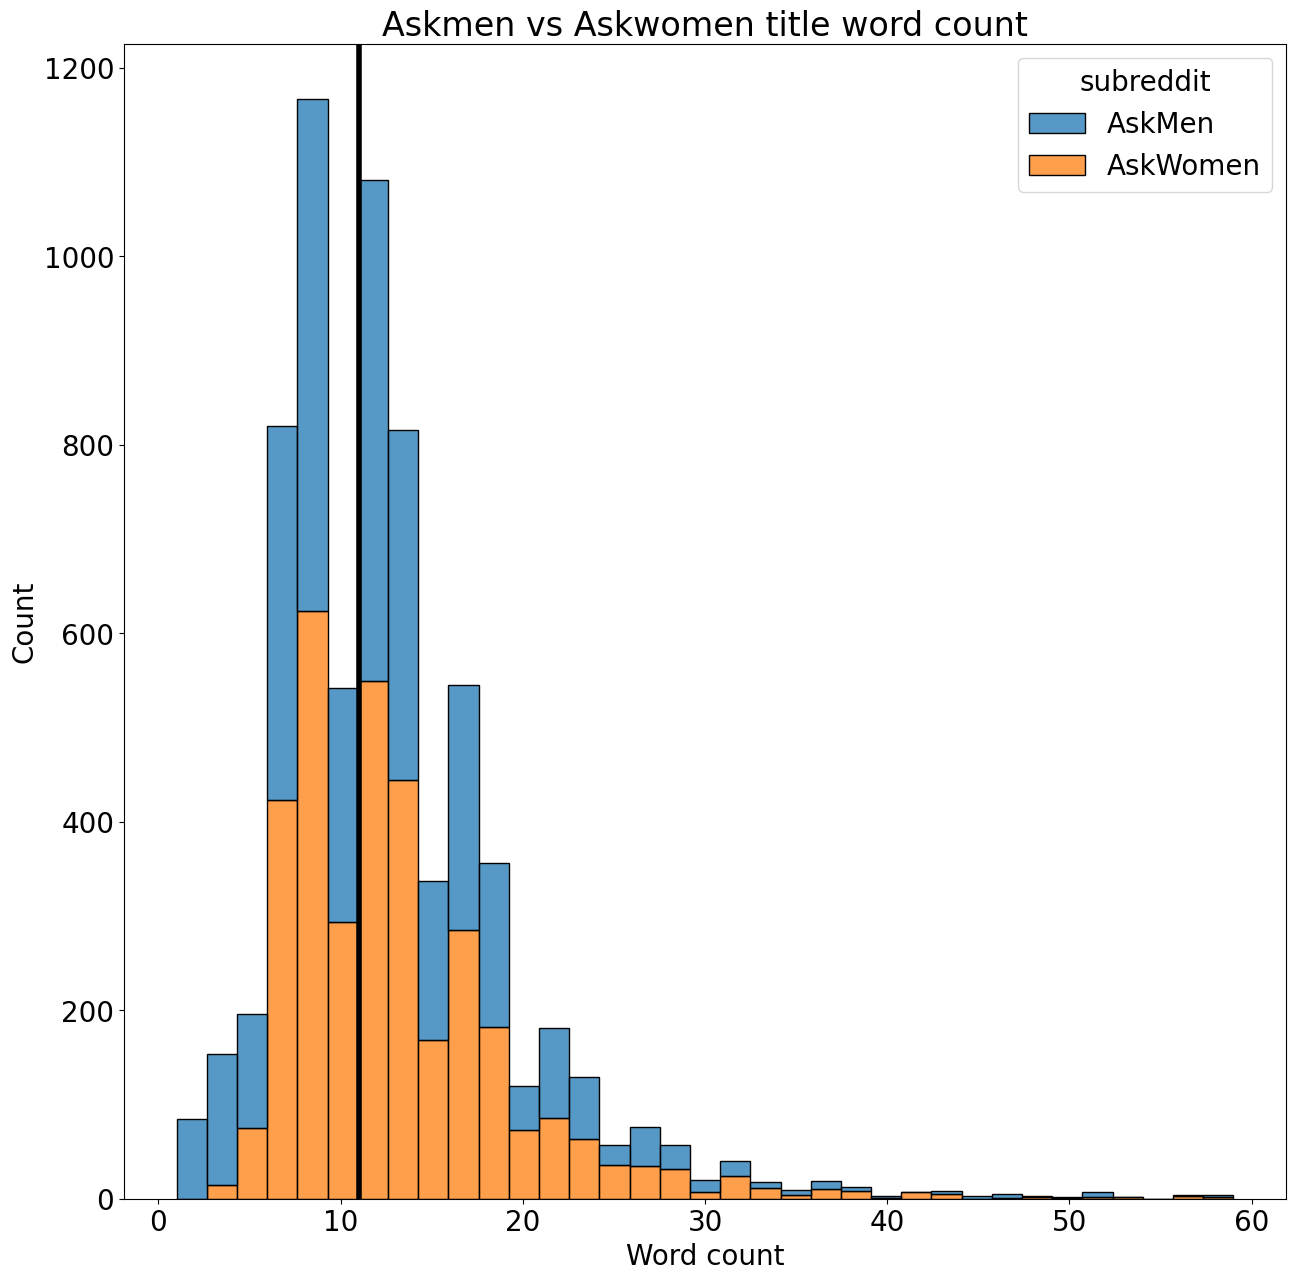

In [122]:
plt.figure(figsize=(15,15))
sns.histplot(data= clean_df_2, multiple ="stack", x = 'title_word_count', hue='subreddit', bins=35)
plt.axvline(x=clean_df_2['title_word_count'].median(), color='black', linewidth=4)
plt.title('Askmen vs Askwomen title word count')
plt.xlabel("Word count")

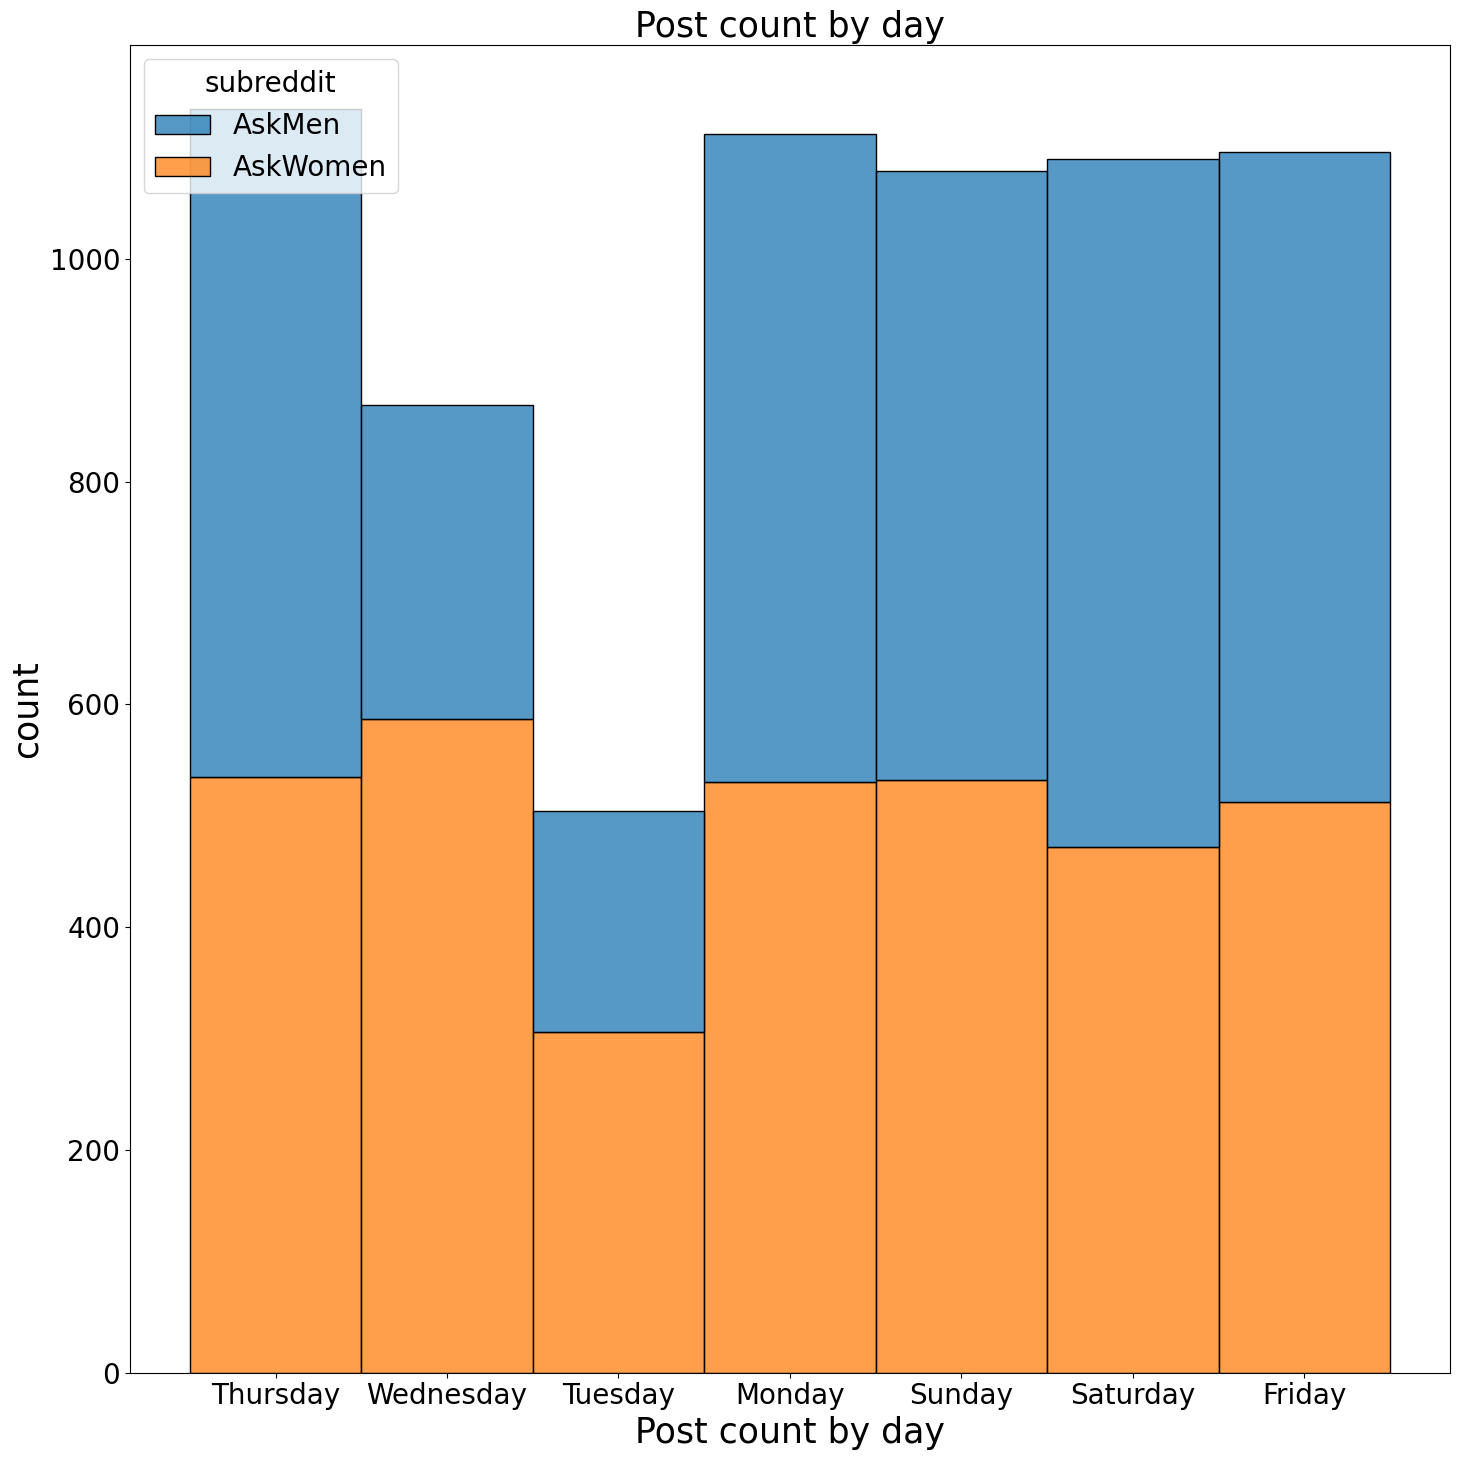

In [123]:
#Overview of post frequencies by day
plt.figure(figsize=(15,15))
sns.histplot(data= clean_df_2, multiple ="stack", x = 'day_name', hue='subreddit')
plt.title('Post count by day', size = 25)
plt.xlabel("Post count by day", size = 25)
plt.ylabel('count', size = 25)
plt.tight_layout()
plt.savefig('../Figures/eda/activity_by_day');

Interestingly the distribution of post titles and days posted are similar. For another project, we can see if this trend is true across other subreddits. 

## Sentiment analysis

In [124]:
sent = SentimentIntensityAnalyzer()

In [125]:
#splitting scores into columns
clean_df_2['negative_score'] = [sent.polarity_scores(clean_df_2['title'][i])['neg'] for i in range(len(clean_df_2['title']))]
clean_df_2['neutral_score'] = [sent.polarity_scores(clean_df_2['title'][i])['neu'] for i in range(len(clean_df_2['title']))]
clean_df_2['positive_score'] = [sent.polarity_scores(clean_df_2['title'][i])['pos'] for i in range(len(clean_df_2['title']))]
clean_df_2['compound_score'] = [sent.polarity_scores(clean_df_2['title'][i])['compound'] for i in range(len(clean_df_2['title']))]

In [126]:
clean_df_2.head(2)

,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score
id,,,,,,,,,,
z99f3w,AskMen,what do athlete think about having some things...,2022-12-01 01:03:02,21,Thursday,12,0.0,0.859,0.141,0.2023
z991l7,AskMen,Why is the idea of permanent sleep so appealing?,2022-12-01 00:47:36,38,Thursday,9,0.0,1.000,0.000,0.0000


<AxesSubplot:title={'center':'Negative setiment score histogram'}, xlabel='Negative sentiment score', ylabel='Count'>

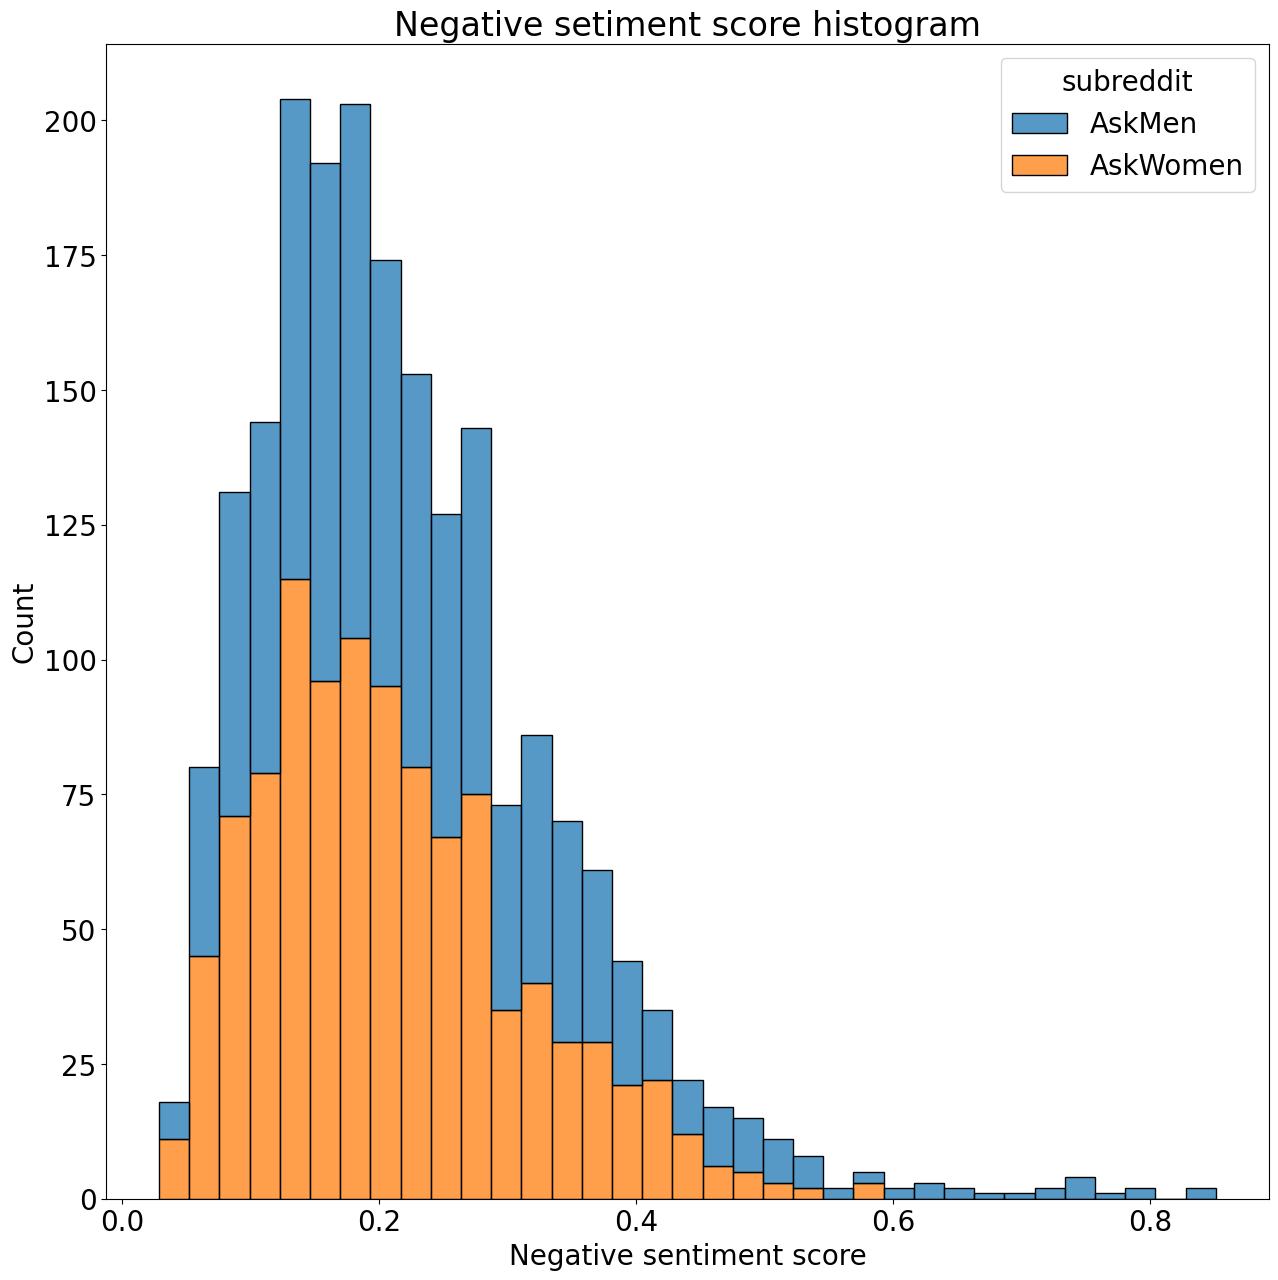

In [127]:
#greater than 0 to get all Negative scores
plt.figure(figsize=(15,15))
plt.title('Negative setiment score histogram')
plt.xlabel('Negative sentiment score')
sns.histplot(data= clean_df_2[clean_df_2['negative_score']>0], multiple ="stack", x = 'negative_score', hue='subreddit', bins=35)

<AxesSubplot:title={'center':'Neutral setiment score histogram'}, xlabel='Neutral sentiment score', ylabel='Count'>

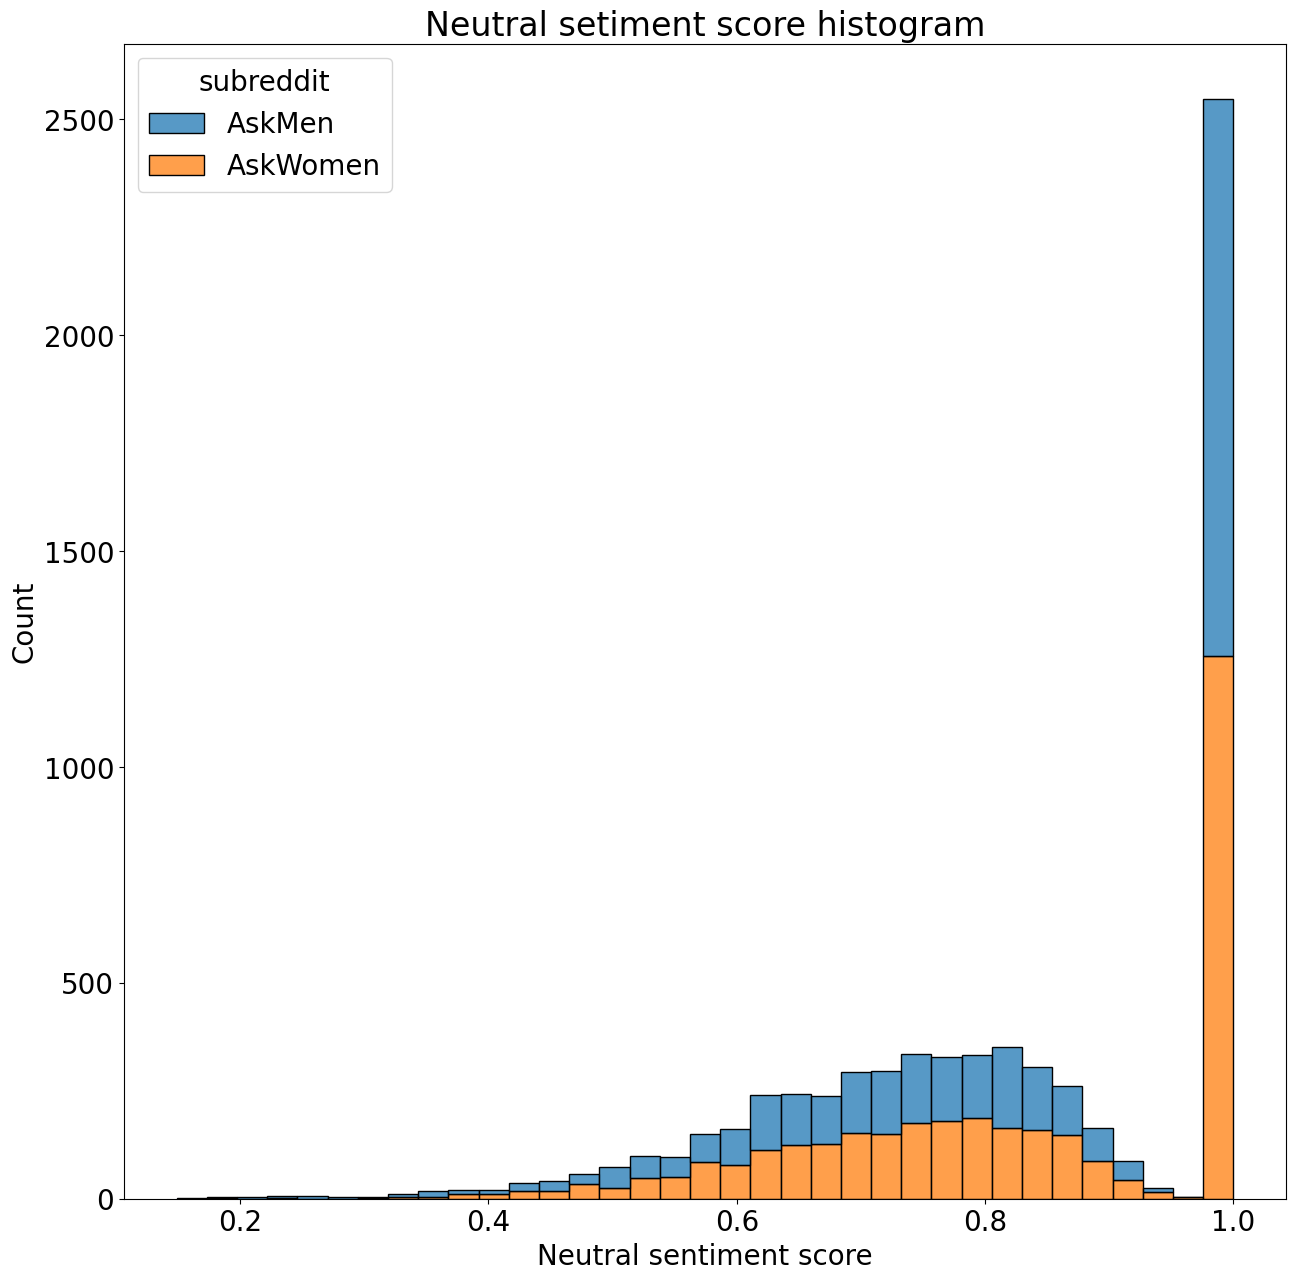

In [128]:
#greater than 0 to get all neutral scores
plt.figure(figsize=(15,15))
plt.title('Neutral setiment score histogram')
plt.xlabel('Neutral sentiment score')
sns.histplot(data= clean_df_2[clean_df_2['neutral_score']>0], multiple ="stack", x = 'neutral_score', hue='subreddit', bins=35)

<AxesSubplot:title={'center':'Positive setiment score histogram'}, xlabel='Positive sentiment score', ylabel='Count'>

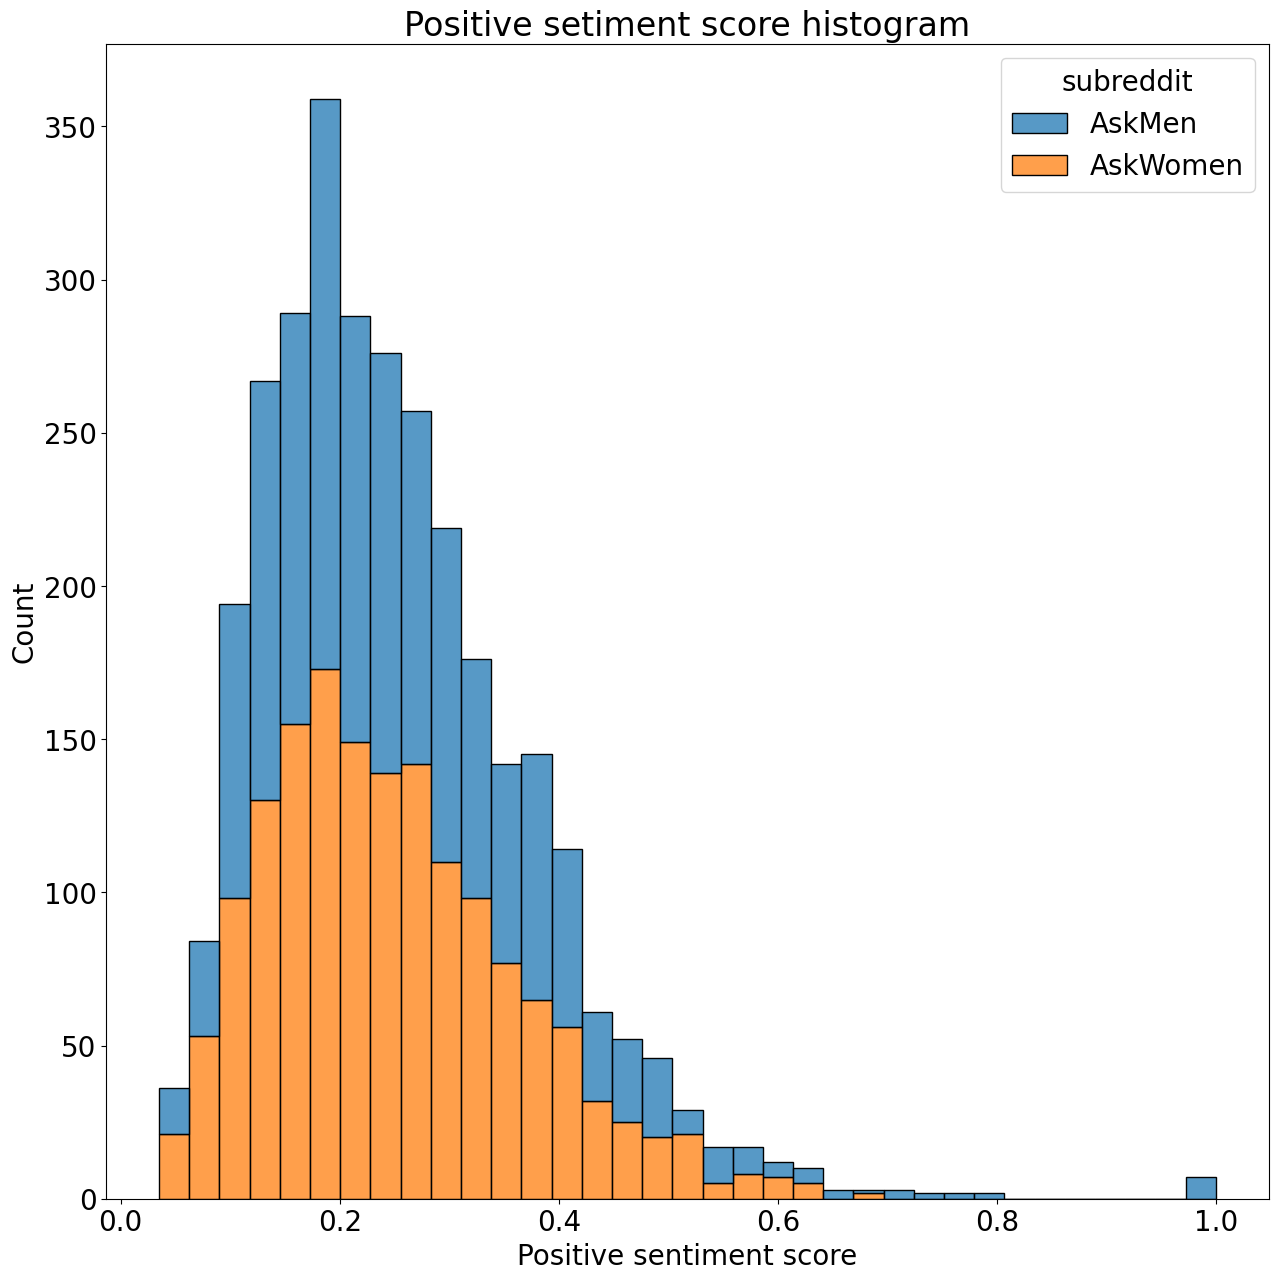

In [129]:
#greater than 0 to get all positive scores
plt.figure(figsize=(15,15))
plt.title('Positive setiment score histogram')
plt.xlabel('Positive sentiment score')
sns.histplot(data= clean_df_2[clean_df_2['positive_score']>0], multiple ="stack", x = 'positive_score', hue='subreddit', bins=35)

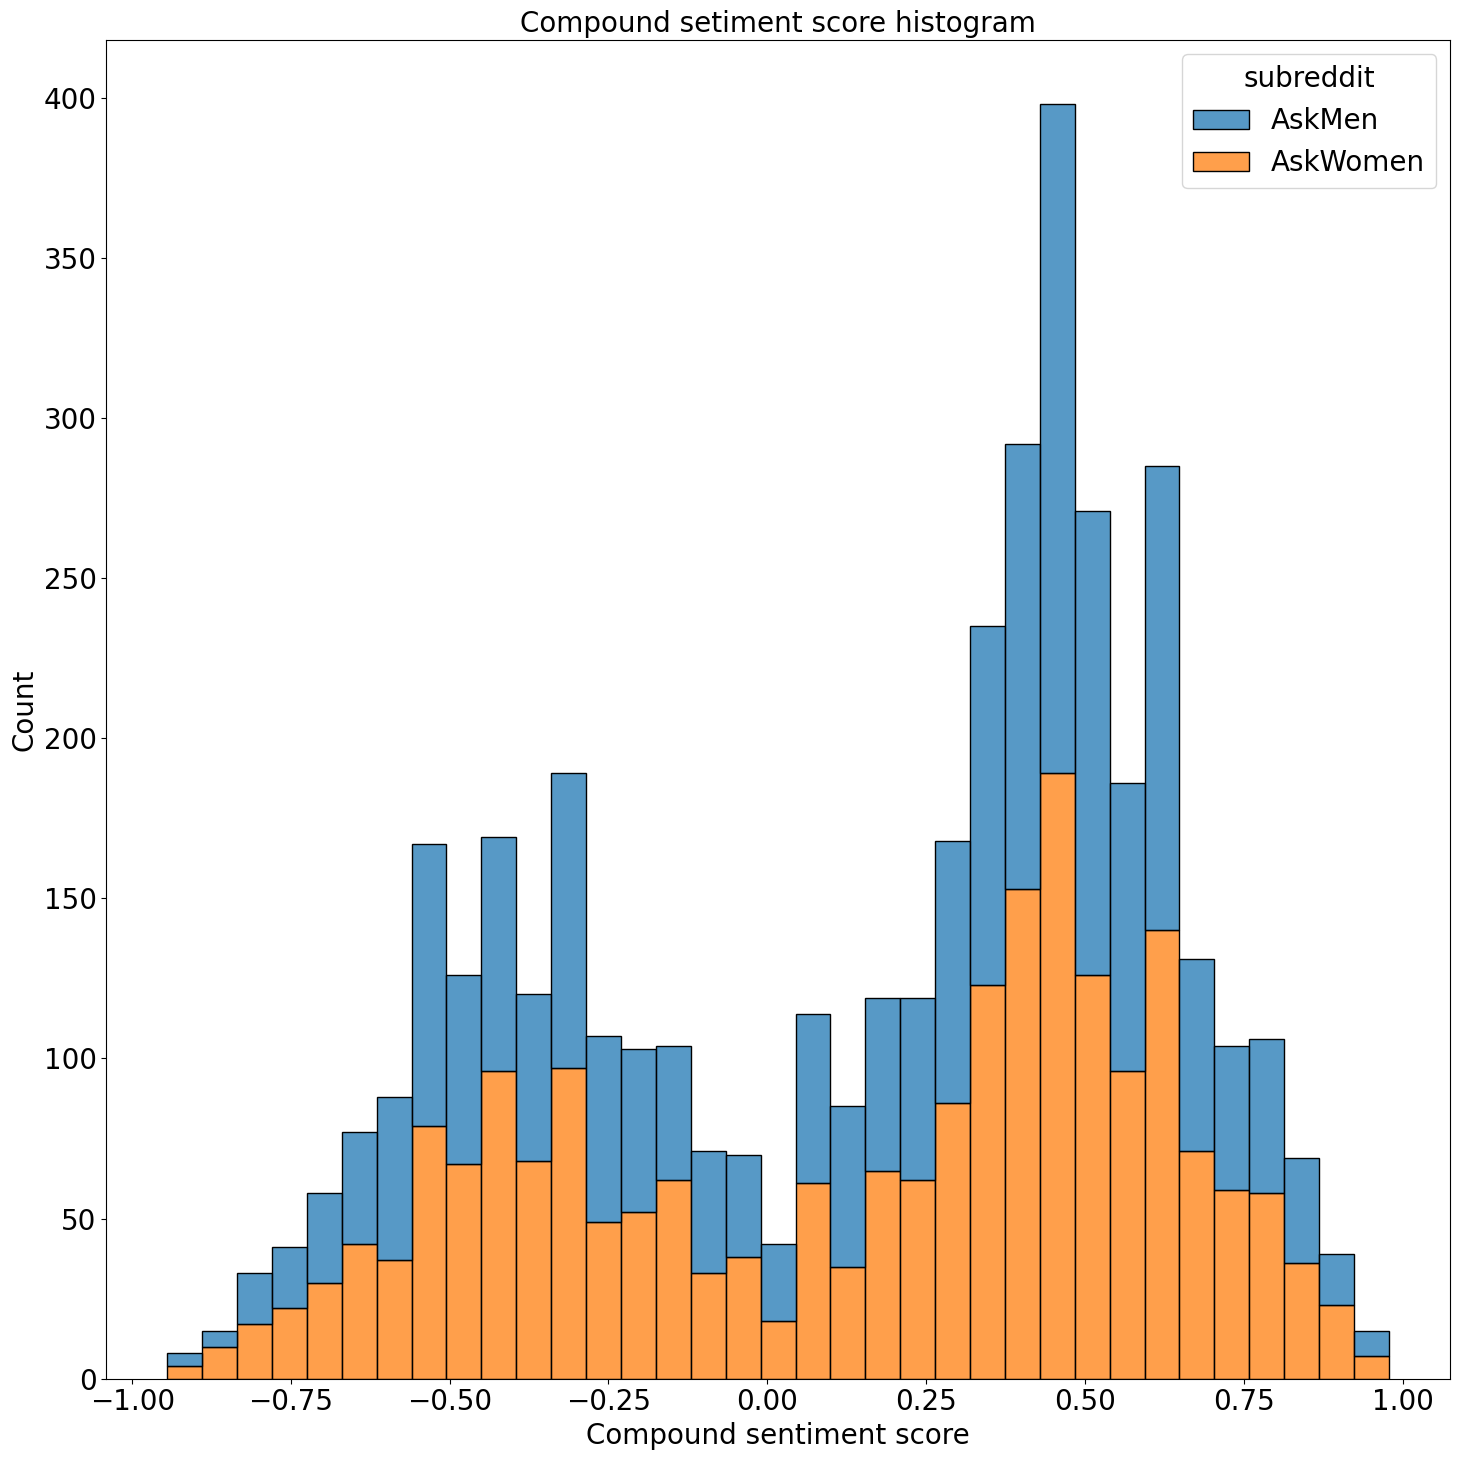

In [130]:
# not equal to 0 so we see the negative or positive values
plt.figure(figsize=(15,15))
plt.title('Compound setiment score histogram', size = 20)
plt.xlabel('Compound sentiment score', size = 20)
plt.ylabel('Count',size = 20)
sns.histplot(data= clean_df_2[clean_df_2['compound_score']!=0], multiple ="stack", x = 'compound_score', hue='subreddit', bins=35)
plt.tight_layout()
plt.savefig('../Figures/eda/compound_sentment.png')

Again we see a similar distribution between the subredits when looking at sentiment score as well. These subreddits appear to be more similar than I thought.

## Checking the number of comments column

In [131]:
clean_df_2['num_comments'].value_counts().head(15)

1     2025
0     1449
5      153
6      139
8      119
7      103
10      94
9       93
12      92
13      89
11      88
17      78
15      69
14      68
22      66
Name: num_comments, dtype: int64

After incorporating the minimum comments feature in our [Data Collection notebook](../Code/01_data_collecting.ipynb) our comment count is a lot more varied.

### Checking removed column

Because we kept the original data set we have a lot of removed post, but since incorporating out data filter we only got 51 removed post. Still the removed post makes up For future projects, we can build a bot to classify a post that violates community guidelines and alert mods or remove it completly.

In [132]:
# create a removed count for our original data frame so we can compare how many new removed post we have
clean_df = clean_df.merge(df['removed_by_category'], left_index=True, right_index=True)
clean_df['is_removed'] = clean_df['removed_by_category'].notnull().astype(int)
clean_df.head(2)

,id,subreddit,title,utc_datetime_str,num_comments,removed_by_category,is_removed
0,12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,0,automod_filtered,1
1,12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,1,moderator,1


In [133]:
#See the percentage of removed post and non-removed post as a percentage
clean_df['is_removed'].value_counts(normalize=True)

1    0.747495
0    0.252505
Name: is_removed, dtype: float64

In [134]:
#see removed post as whole numbers
clean_df['is_removed'].value_counts()

1    2984
0    1008
Name: is_removed, dtype: int64

In [135]:
df2.set_index('id', inplace=True)
#get the removed by category from the orignal df to calculate the ammount of removedp ost in each subreddit
clean_df_2 = clean_df_2.merge(df2['removed_by_category'], left_index=True, right_index=True)
#NaNs indicate that a post was or was not removed,


In [136]:
clean_df_2['is_removed'] = df2['removed_by_category'].notnull().astype(int)
#create a dataframe of the number of post removed in a subreddit
subreddit_2 = clean_df_2.groupby('subreddit')['is_removed'].sum().reset_index()

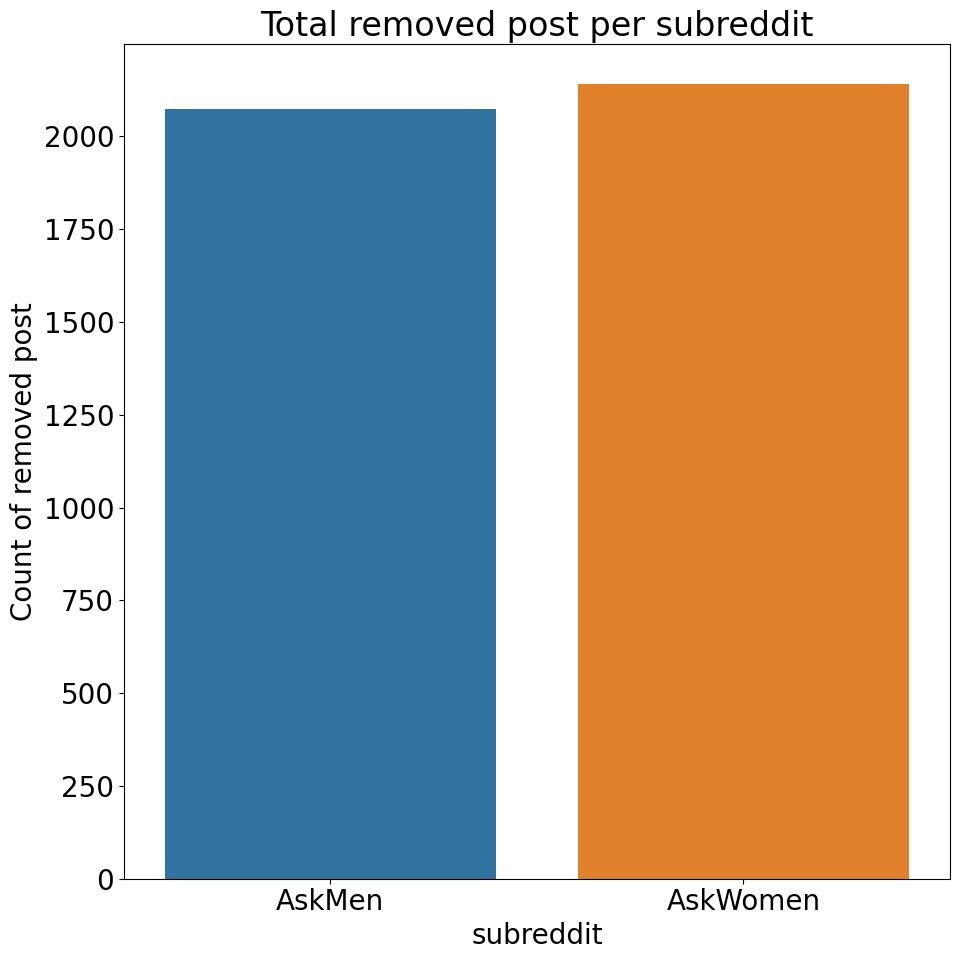

In [137]:
#plot the total number of post removed in each sub reddit
plt.figure(figsize=(10,10))
plt.title("Total removed post per subreddit")
sns.barplot(x = 'subreddit', y = 'is_removed', data = subreddit_2)
plt.ylabel('Count of removed post')
plt.tight_layout()
plt.savefig('../Figures/eda/total_removed_posts.png')

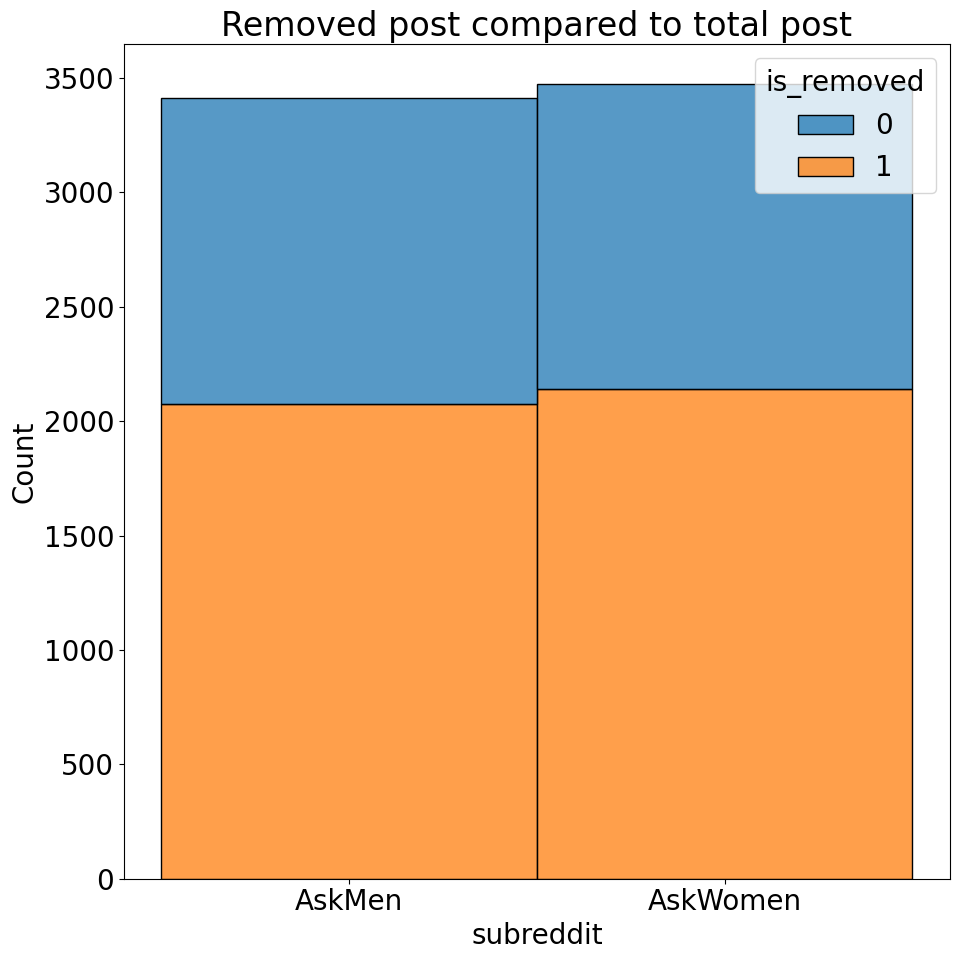

In [138]:
plt.figure(figsize=(10,10))
plt.title('Removed post compared to total post')
sns.histplot(data= clean_df_2, multiple ="stack", x = clean_df_2['subreddit'], hue='is_removed', bins=35)
plt.tight_layout()
plt.savefig('../Figures/eda/stacked_removed_posts.png')

In [139]:
#finds the ammount of removed post in the new dataset my subtracting the old number of removed post.
(clean_df_2[clean_df_2['removed_by_category']=='moderator']['is_removed'].sum() - clean_df[clean_df['removed_by_category']=='moderator']['is_removed'].sum())

447

Here we noticed the number of removed post to none removed post is not as significant as our first iteration. In fact, after applying the minimum comment filter we were able to go from pulling 2660 removed post to only pulling 447 removed post.

## Export clean csv

In [140]:
clean_df_2.to_csv('../Data/02_sub_reddit_data_clean.csv')

# Vectorizing title data

In [141]:
vect_df_2 = pd.read_csv('../Data/02_sub_reddit_data_clean.csv')

In [142]:
cvec = CountVectorizer(stop_words = 'english')

In [143]:
X_2= vect_df_2['title']
X_cv_2 = cvec.fit_transform(X_2)
X_cv_2.shape

(6885, 6106)

In [144]:
words_df_2 = pd.DataFrame(X_cv_2.todense(), columns=cvec.get_feature_names_out())
words_df_2.head()

,000,00pm,00s,0ft,10,100,1000,10k,10yr,11,...,yrs,yung,zaralynn,zealand,zero,zodiac,zombie,zone,zoned,zoning
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In our initial vectorizer we noticed Russian characters, but after implementing the ascii method we were able to filter out non alphanumerical characters.

In [145]:
women_word_2 = words_df_2[vect_df_2['subreddit'] == 'AskWomen'].sum().sort_values(ascending=False)
men_word_2 = words_df_2[vect_df_2['subreddit'] == 'AskMen'].sum().sort_values(ascending=False)

## Visualizing top 10 words

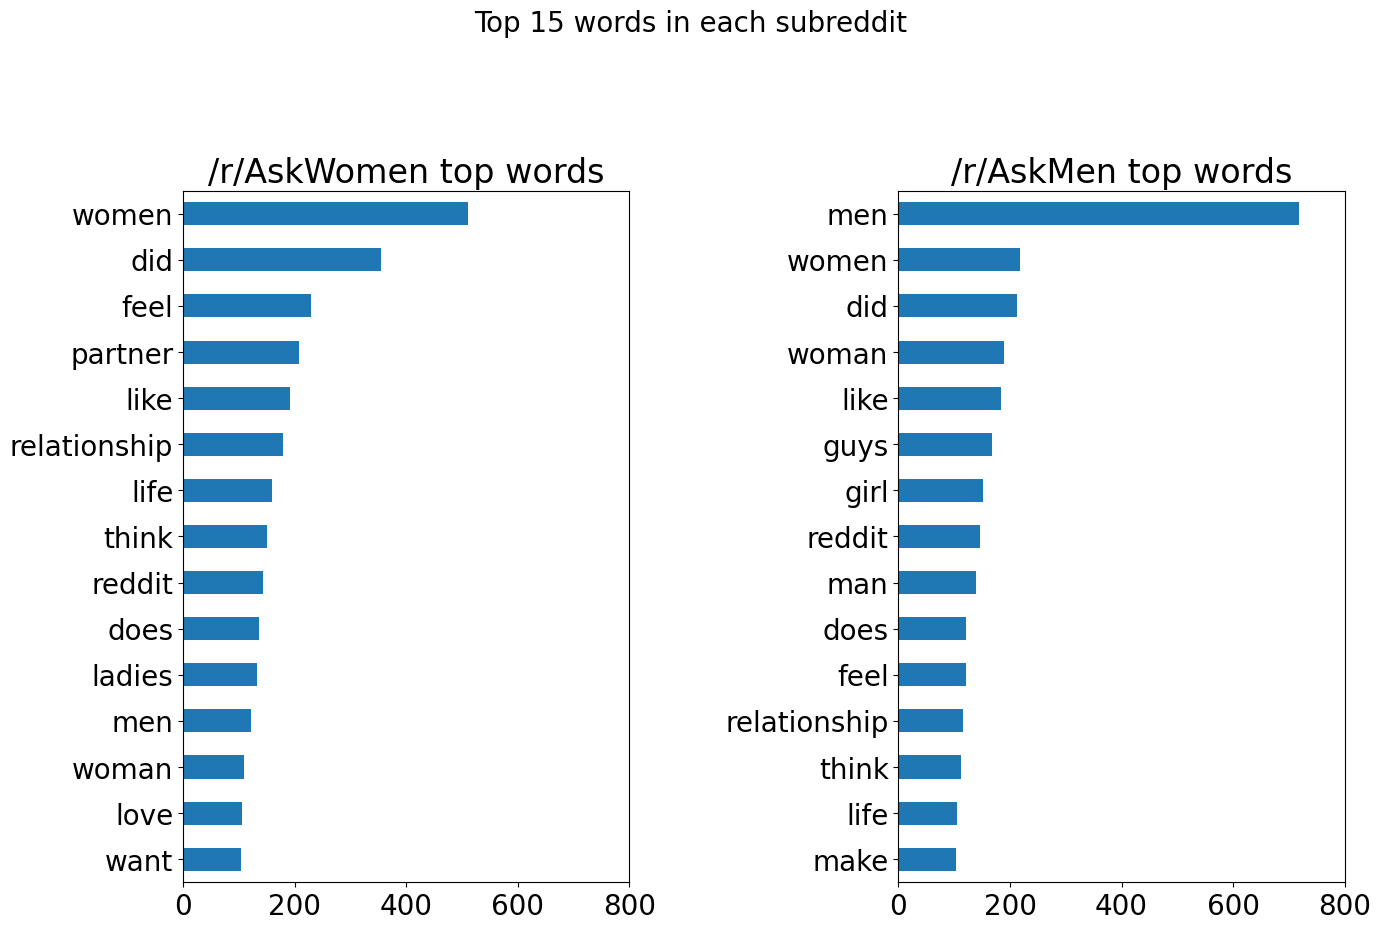

In [162]:
fig, a = plt.subplots(1,2, figsize=(15,10))
plt.suptitle('Top 15 words in each subreddit', fontsize= 20)
a[0].set_title('/r/AskWomen top words')
a[0].set_xlim([0, 800])
a[1].set_xlim([0, 800])
a[1].set_title('/r/AskMen top words')
women_word_2.head(15).plot(kind = 'barh', ax=a[0]).invert_yaxis()
men_word_2.head(15).plot(kind = 'barh', ax=a[1]).invert_yaxis()
fig.tight_layout(pad=2.5)
plt.savefig('../Figures/eda/top_ten_words')

Looking at the top ten words within the subreddits we see that the terms women and men have about equal usage in each subreddit. Orginally we thought one would be more common in the respective subreddit, but since they get equal use we can keep those words in out vector.

## Bigrams and trigrams

In [147]:
# get the subreddit, and n_gram range
def n_gramer(sub, num1, num2):
    #instiatiate countvectorize with placeholders for N gram range
    bi_cvec = CountVectorizer(stop_words= 'english', ngram_range=(num1,num2))
    #assigned the title so we can fit
    bi_X_2= vect_df_2['title']
    #fit and transform title
    bi_X_cv_2 = bi_cvec.fit_transform(bi_X_2)
    #create the n as a data frame
    bi_words_df_2 = pd.DataFrame(bi_X_cv_2.todense(), columns=bi_cvec.get_feature_names_out())
    #return a mask of the dataframe with the specified subreddit
    return bi_words_df_2[vect_df_2['subreddit'] == sub].sum().sort_values(ascending=False)

### Bigrams

In [148]:
bi_men_word = n_gramer('AskMen', 2 ,2)
bi_men_word.head(10)

men reddit     132
long term       21
men think       20
best friend     18
does mean       18
year old        17
did turn        14
best way        14
feel like       13
make feel       13
dtype: int64

In [149]:
bi_women_word = n_gramer('AskWomen', 2 ,2)
bi_women_word.head(10)

women reddit    109
make feel        19
feel like        19
social media     19
best friend      18
did feel         17
long term        16
look like        16
did realize      15
best way         14
dtype: int64

## Trigram

In [150]:
tri_men_word = n_gramer('AskMen', 3 ,3)
tri_men_word.head(10)

men lead woman            12
did turn end              11
turn end happened         11
woman did turn            11
lead woman did            11
long term relationship     8
men reddit did             7
dear men reddit            5
female best friend         5
friend want maid           5
dtype: int64

In [151]:
tri_women_word = n_gramer('AskWomen', 3 ,3)
tri_women_word.head(10)

women reddit feel         7
women reddit did          7
casual convo fridays      6
long term relationship    6
june 2023 preparation     5
reasons like dangerous    5
dated nice guy            5
join jrf english          5
english june 2023         5
obvious reasons like      5
dtype: int64

In [152]:
print(df2['title'][df2['title'].str.contains('JRF')])

id
12xke1w    How can someone in Kashmir join me for JRF(Eng...
12xk64i    How can someone in Kashmir join me for JRF(Eng...
12xjyad    How can I make a study club in Kashmir for Jun...
12xjnip    I wish someone in Kashmir could join me for JR...
12xj7q4    I wish students from kashmir could join me for...
12xiyjj    Who in Kashmir wants to join me for JRF(Englis...
Name: title, dtype: object


## Quadgram

In [153]:
tri_men_word = n_gramer('AskMen', 4 ,4)
tri_men_word.head(10)

lead woman did turn                 11
did turn end happened               11
men lead woman did                  11
woman did turn end                  11
friend want maid room                5
men enter romantic relationships     3
16m scared need help                 3
pressure men enter romantic          3
actually view girl differently       3
friends attractive female best       3
dtype: int64

In [154]:
tri_women_word = n_gramer('AskWomen', 4 ,4)
tri_women_word.head(10)

jrf english june 2023              5
join jrf english june              5
english june 2023 preparation      5
obvious reasons like dangerous     5
tutors india available studying    4
notch tutors india available       4
june 2023 preparation lot          4
content bought notch tutors        4
preparation lot content bought     4
kashmir join jrf english           4
dtype: int64

# Findings

Here it appears there's nothing of concern except for JR, but upon research the term JRF, it appears to stand for Junior Research Fellowship. Using single grams the most notable words were:
1) ) Women
2) ) Men
3) ) Relationship
4) ) Partner

When using bigrams I noticed these pattern within both subreddit:
1) ) Relationships
2) ) Friendships
3) ) Feelings

Unique to the women subreddit I noticed women talking about feelings and social media. Unique to the men subreddit I noticed a recurrence of the word "lead". Which I can assume who takes the lead in a relationship.

Interestingly when I used quadgrams I noticed the Askwomen subreddit mentions a lot of study groups for the Junior Research Fellowship (JRC). The only most notable one though was the quadgram "obvious reasons like dangerous". Which upon further inspection it was related to relationships. Additionally it appears to be a duplicate value, but looking at the post IDs these are unique so we will keep these values.

From here we can move onto our [modeling stage](../Code/03_modeling.ipynb)